# Energy Flows for PV ICE

This journal documents and demonstrates the new Energy flows calculation capacity of PV ICE

In [1]:
import os
from pathlib import Path
import PV_ICE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')

# Another option using relative address; for some operative systems you might need '/' instead of '\'
# testfolder = os.path.abspath(r'..\..\PV_ICE\TEMP')  

print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP


In [2]:
PV_ICE.__version__

'v0.2.0+147.gf20f664.dirty'

### Add Scenarios and Materials

In [3]:
cwd=os.getcwd()
print(os.getcwd())

C:\Users\hmirletz\Documents\GitHub\PV_ICE\docs\tutorials


In [4]:
MATERIALS = ['glass']#,'aluminium_frames','silver','silicon', 'copper', 'encapsulant', 'backsheet']
MATERIAL = MATERIALS[0]

moduleFile_linear = r'..\baselines\perovskite_modules_US_linear.csv'

In [5]:
r1 = PV_ICE.Simulation(name='perovskite_energies', path=testfolder)

r1.createScenario(name='perovskite_linear', file=moduleFile_linear)
for mat in range (0, len(MATERIALS)):
    MATERIALBASELINE = r'..\baselines\perovskite_material_'+MATERIALS[mat]+'.csv'
    r1.scenario['perovskite_linear'].addMaterial(MATERIALS[mat], file=MATERIALBASELINE)


path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP


### Run the Mass Flow Calculations on All Scenarios and Materials

In [6]:
r1.calculateMassFlow()

Working on Scenario:  perovskite_linear
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass


## Calculating Energy Flows

First read in the energy files. Point at a path, then use the PV ICE colde to handle the meta data. 

Energy values for modules are in kWh/m2 and for materials are in kWh/kg. To ensure unit matching, we will divide the input by 1000 to convert kg to g.

In [7]:
matEfile_glass = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines'/'perovskite_energy_material_glass.csv')

modEfile = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines'/'perovskite_energy_modules.csv')

In [8]:
file = matEfile_glass
csvdata = open(str(file), 'r', encoding="UTF-8")
csvdata = open(str(file), 'r', encoding="UTF-8-sig")
firstline = csvdata.readline()
secondline = csvdata.readline()

head = firstline.rstrip('\n').split(",")
meta = dict(zip(head, secondline.rstrip('\n').split(",")))

data = pd.read_csv(csvdata, names=head)
data.loc[:, data.columns != 'year'] = data.loc[:, data.columns != 'year'].astype(float)/1000 
#Divide by 1000 go get kg to g
# THIS IS A TEMP FIX
matEfile_glass_simple = data.copy()

In [9]:
file = modEfile
csvdata = open(str(file), 'r', encoding="UTF-8")
csvdata = open(str(file), 'r', encoding="UTF-8-sig")
firstline = csvdata.readline()
secondline = csvdata.readline()

head = firstline.rstrip('\n').split(",")
meta = dict(zip(head, secondline.rstrip('\n').split(",")))

data = pd.read_csv(csvdata, names=head)
data.loc[:, data.columns != 'year'] = data.loc[:, data.columns != 'year'].astype(float)
modEfile_simple = data.copy()

Now run the energy calculation. Currently this is not a class, just a function that will return a dataframe. Each scenario will need to be run seperately, and read in the perovskite energy files.

In [10]:
r1_e_linear = r1.calculateEnergyFlow(scenarios='perovskite_linear', materials='glass', modEnergy=modEfile_simple, matEnergy=matEfile_glass_simple)


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


## Energy Analysis

In [11]:
r1_e_linear.keys()

Index(['mod_MFG', 'mod_Install', 'mod_OandM', 'mod_Repair', 'mod_Demount',
       'mod_Store', 'mod_Resell_Certify', 'mod_ReMFG_Disassembly',
       'mod_Recycle_Crush', 'mat_extraction', 'mat_MFG', 'mat_MFGScrap_LQ',
       'mat_MFGScrap_HQ', 'mat_Landfill', 'mat_EoL_ReMFG_clean',
       'mat_Recycled_LQ', 'mat_Recycled_HQ'],
      dtype='object')

In [14]:
r1_e_linear.index = modEfile_simple['year'] #temp fix to reassign years to this dataframe

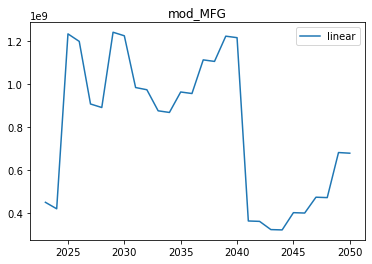

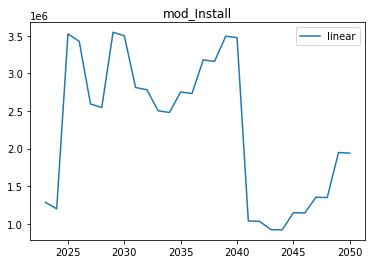

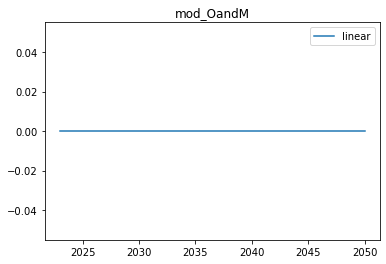

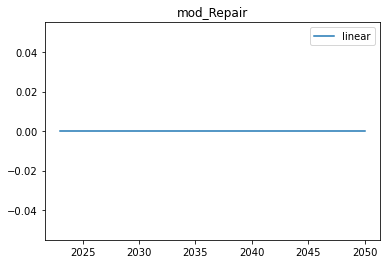

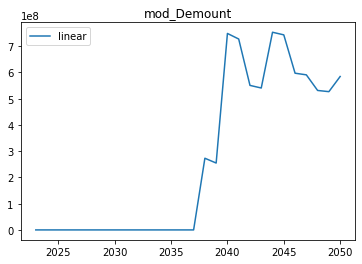

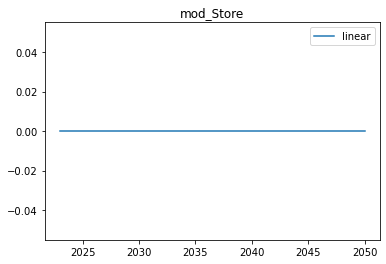

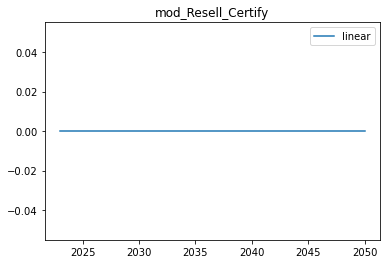

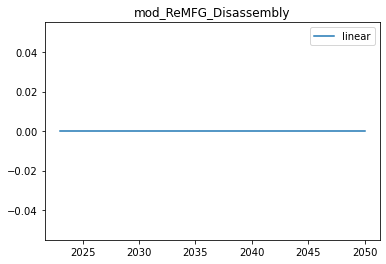

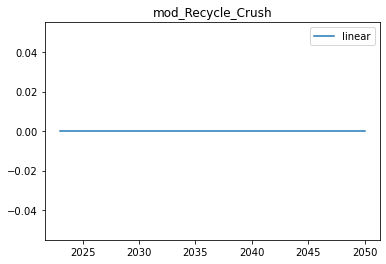

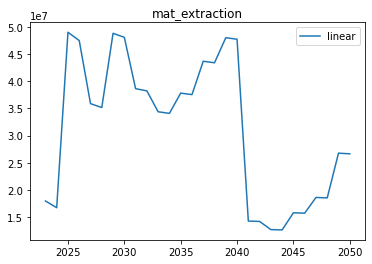

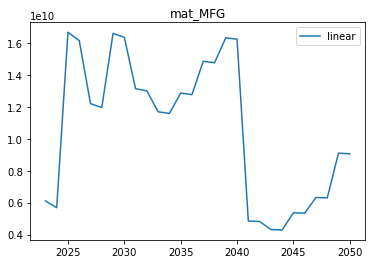

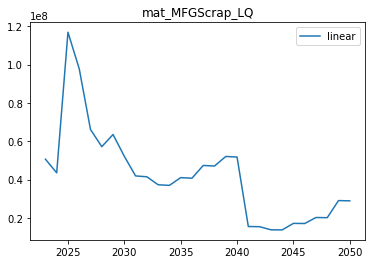

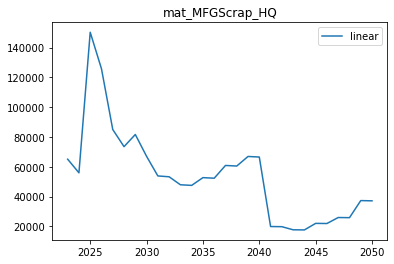

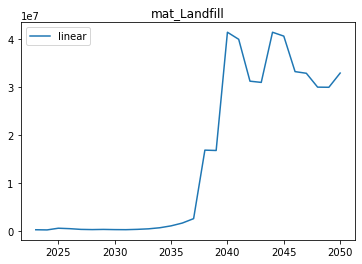

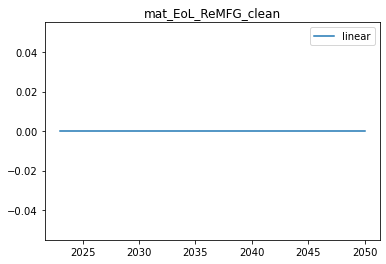

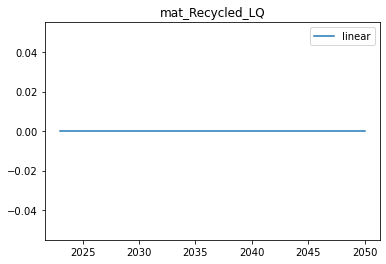

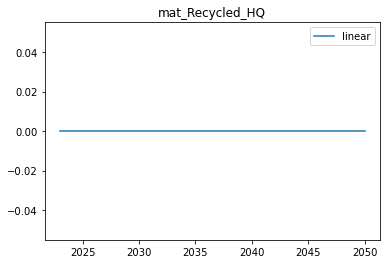

In [15]:
for key in r1_e_linear.keys():
    plt.plot(r1_e_linear.index, r1_e_linear[key], label='linear')
    plt.legend()
    plt.title(str(key))
    plt.show()